<a href="https://colab.research.google.com/github/vmatiasw/modelos_y_simulacion/blob/main/P6E9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

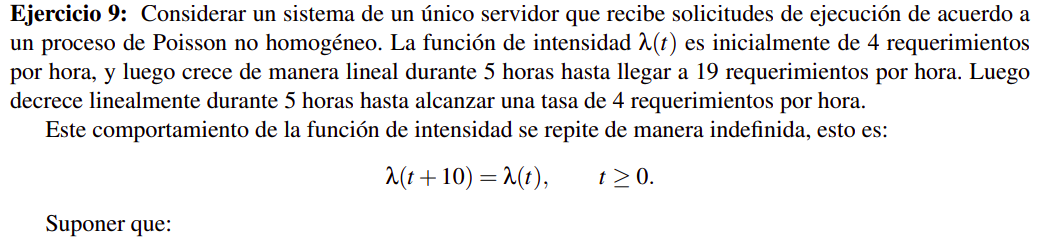

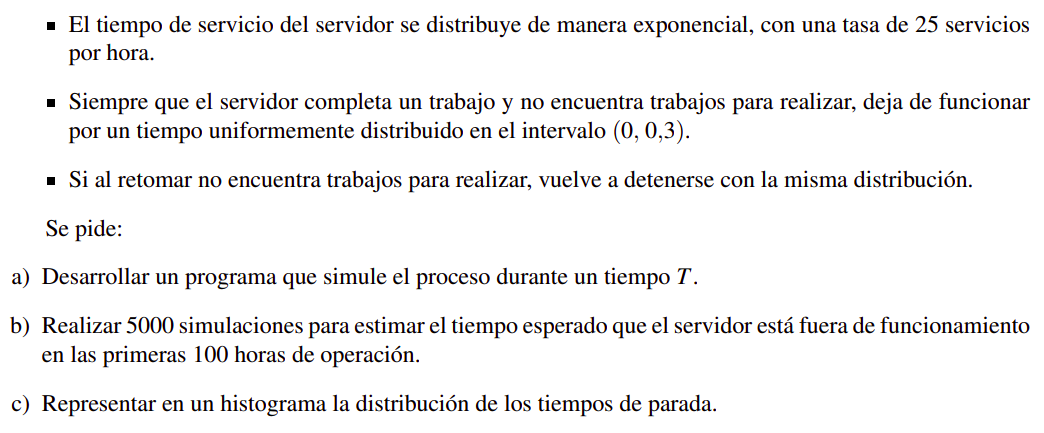

min: 4, max: 19


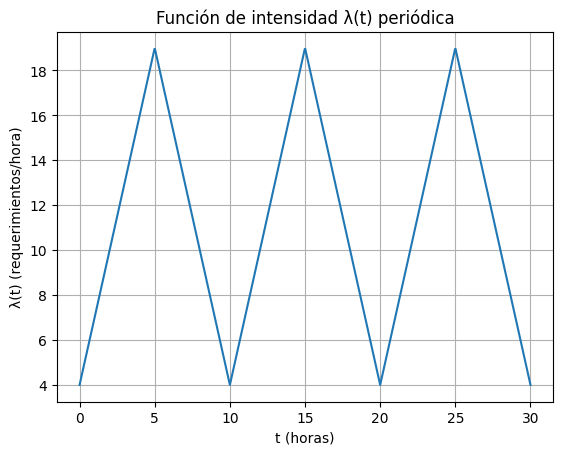

In [115]:
import numpy as np
from random import random, seed
import matplotlib.pyplot as plt
import seaborn as sns

def lambda_t(t):
    """Función de intensidad λ(t) para proceso de Poisson no homogéneo periódico."""
    return abs(((t-5) % 10 - 5) * 3) + 4

print(f"min: {lambda_t(0)}, max: {lambda_t(5)}")

t_vals = np.linspace(0, 30, 1000)
lambda_vals = lambda_t(t_vals)

plt.plot(t_vals, lambda_vals)
plt.title("Función de intensidad λ(t) periódica")
plt.xlabel("t (horas)")
plt.ylabel("λ(t) (requerimientos/hora)")
plt.grid(True)
plt.show()

In [116]:
def tiempo_exponencial(tasa):
  return -np.log(1 - random()) / tasa

def generar_PPNH(func_intensidad, max_intensidad, tiempo_total):
  tiempo_eventos = []
  tiempo_acumulado = tiempo_exponencial(max_intensidad)

  while tiempo_acumulado <= tiempo_total:
    if random() < func_intensidad(tiempo_acumulado) / max_intensidad:
      tiempo_eventos.append(tiempo_acumulado)

    tiempo_acumulado += tiempo_exponencial(max_intensidad)

  return tiempo_eventos

def simular_cola_un_servidor(horas_totales=100, tasa_servicio=25):
  _rangos_desocupados = []
  arribos_pendientes = generar_PPNH(lambda_t, 19, horas_totales)
  reloj = 0.0
  cola = []
  while reloj < horas_totales:
    if cola: # si hay clientes en la cola
      # atendemos al 1er cliente de la cola
      inicio_servicio = reloj
      llegada = cola.pop(0)
      duracion_servicio = tiempo_exponencial(tasa_servicio)
      reloj += duracion_servicio # saltamos al fin de su atencion

    elif 0 < len(arribos_pendientes): # si no hay cola y aun llegaran clientes
      proximo_arribo = arribos_pendientes[0]
      _rangos_desocupados.append([reloj, None])
      while reloj < proximo_arribo:
        reloj += random()*3
      _rangos_desocupados[-1][1] = reloj
      cola.append(arribos_pendientes.pop(0)) # agregamos al 1er cliente que llego a la cola

    else: break

    # actualizamos la cola con los que llegaron mientras el servidor estaba
    # ocupado (atendiendo a algun cliente) o detenido
    while 0 < len(arribos_pendientes) and arribos_pendientes[0] <= reloj:
      cola.append(arribos_pendientes.pop(0))

  return _rangos_desocupados

In [117]:
N_SIM = 500
HORAS_TOTALES = 100
simulaciones = [simular_cola_un_servidor(HORAS_TOTALES) for _ in range(N_SIM)]
simulaciones_aplanadas = [r for s in simulaciones for r in s]
tiempos_desocupados = [r[1] - r[0] for r in simulaciones_aplanadas]
t_prom_desocupado = sum(tiempos_desocupados) / N_SIM
print(f"Tiempo desocupado promedio en {HORAS_TOTALES} horas: {t_prom_desocupado}")

Tiempo desocupado promedio en 100 horas: 54.82590654378792


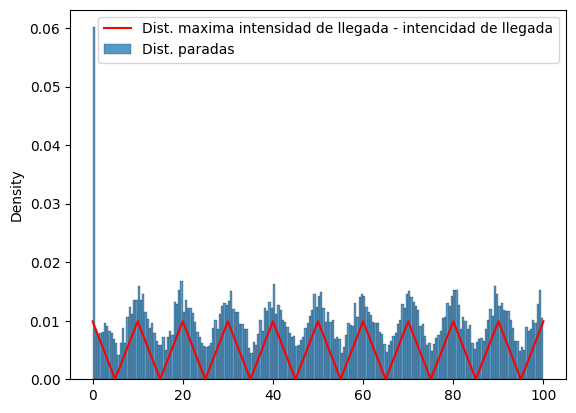

In [118]:
BINS = HORAS_TOTALES*2
TIEMPOS = np.linspace(0, HORAS_TOTALES, BINS+1)

intensidades = 19 - lambda_t(TIEMPOS)
fdp_intensidades = intensidades / sum(intensidades)

tiempo_paradas = [r[0] for r in simulaciones_aplanadas]
sns.histplot(tiempo_paradas, bins=BINS, stat='density', label="Dist. paradas")
sns.lineplot(x=TIEMPOS, y=fdp_intensidades, color='red', label="Dist. maxima intensidad de llegada - intencidad de llegada")
plt.legend()
plt.show()

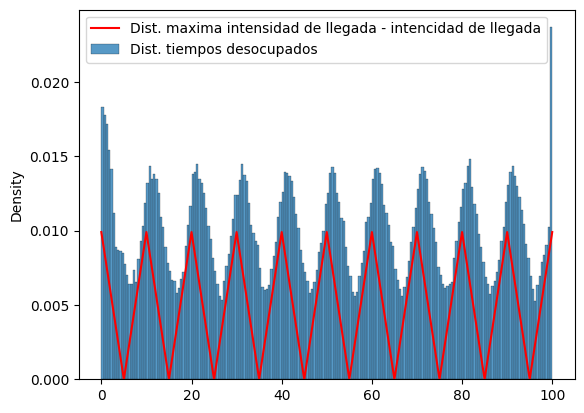

In [119]:
tiempos_desocupados = [
    t
    for s in simulaciones
    for t in TIEMPOS
    if any(r[0] <= t <= r[1] for r in s)
]
sns.histplot(tiempos_desocupados, bins=BINS, stat='density', label="Dist. tiempos desocupados")
sns.lineplot(x=TIEMPOS, y=fdp_intensidades, color='red', label="Dist. maxima intensidad de llegada - intencidad de llegada")
plt.legend()
plt.show()